In [1]:
# !pip3 install matplotlib
# !python3.11 -m pip install --upgrade pip

import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# functions
def sumCellType(cell_type, M):
    # number of type of cell in grid
    return sum(sum(M==cell_type))

def mitosisProb(k, n, p):
    # probability of cell mitosis
    return (k * (1 - n / p))

def originDistance(r, c):
    # calculate grid distance from origin
    return math.sqrt((r - origin[0])**2 + (c - origin[1])**2)

def densityDevelopment(ROWS, COLS, M):
    # calculate density development of tumor
    c = sumCellType('C', M)
    e = sumCellType('E', M)
    d = sumCellType('D', M)
    nPrime = c + e + d
    R = 0
    for i in range(ROWS):
        for j in range(COLS):
            if M[i, j] == 'C':
                R += originDistance(i, j)
    R = R / nPrime
    return nPrime / R**2

def getQuadrant(r, c, origin):
    # get quadrant of coordinates relative to origin
    if r <= origin[0] and c > origin[1]:
	    return 'I'
    elif r <= origin[0] and c <= origin[1]:
	    return 'II'
    elif r > origin[0] and c <= origin[1]:
	    return 'III'
    else:
	    return 'IV'
    
def mitosis(r,c,newM,choice, dense, quadrant):
    # model cell division w/ density development
    up = (r-1, c)
    rt = (r, c+1)
    dn = (r+1, c)
    lt = (r, c-1) 
    denseMap = {'I':[up,rt],'II':[lt,up],'III':[dn,lt],'IV':[rt,dn]}
    notDenseMap = {'I':[dn,lt],'II':[rt,dn],'III':[up,rt],'IV':[lt,up]} 
    notNormal = ('E','D')
    if dense:
        if choice < 0.5 and newM[denseMap[quadrant][0]] not in notNormal:
            newM[denseMap[quadrant][0]] = 'C'
        elif choice >= 0.5 and newM[denseMap[quadrant][1]] not in notNormal:
            newM[denseMap[quadrant][1]] = 'C'
    else:
        if choice < 0.5 and newM[notDenseMap[quadrant][0]] not in notNormal:
            newM[notDenseMap[quadrant][0]] = 'C' 
        elif choice >= 0.5 and newM[notDenseMap[quadrant][1]] not in notNormal: 
            newM[notDenseMap[quadrant][1]] = 'C'

In [79]:
def simulation(k1,k2,k3,k4, rho, ROWS, COLS):
    
    N = []
    C = []
    E = []
    D = []
    
    # initialize grid of normal cells
    M = np.full((ROWS, COLS), 'N')

    # initialize cancer cell(s) in middle of grid
    cancer_init_positions = [(origin[0], origin[1]), (origin[0] + 1, origin[1]), 
                            (origin[0] - 1, origin[1]), (origin[0], origin[1] - 1), 
                            (origin[0], origin[1] + 1)]

    for pos in cancer_init_positions:
        M[pos] = 'C'

    # create copy of matrix to apply changes to
    newM = np.copy(M)

    # Set up the colormap
    cmap = ListedColormap(['white', 'black', 'red', 'gray'])

    # Constants
    save_every_n_generations = 10
    num_plots = generations // save_every_n_generations

    # Set up the figure with a grid of subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(20, 5))  # Adjust figsize as needed

    # Convert cell types to integers for plotting
    cell_to_int = {'N': 0, 'C': 1, 'E': 2, 'D': 3}

    # Initialize counters
    total_transitions = 0
    active_transitions = 0

    # model expansion of tumor for g generations
    for g in range(generations):
        dense = (densityDevelopment(ROWS, COLS, M) > rho)
        for r in range(1, ROWS):
            for c in range(1, COLS):
                quadrant = getQuadrant(r, c, origin)
                if M[r, c] == 'C':
                    if random.random() < mitosisProb(k1, sumCellType('C', M), phi):
                        choice = random.random()
                        mitosis(r,c,newM,choice, dense, quadrant)
                    elif random.random() < k2:
                        newM[r, c] = 'E'
                elif M[r, c] == 'E':
                    if random.random() < k3:
                        newM[r, c] = 'D'
                elif M[r, c] == 'D':
                    if random.random() < k4:
                        newM[r, c] = 'N'

        # Count transitions for this generation
        for r in range(ROWS):
            for c in range(COLS):
                if M[r, c] != newM[r, c]:
                    total_transitions += 1
                    if newM[r, c] == 'C':
                        active_transitions += 1
                        
        N.append(sumCellType('N', M))
        C.append(sumCellType('C', M))
        E.append(sumCellType('E', M))
        D.append(sumCellType('D', M))
        
        M = np.copy(newM)

        if g % save_every_n_generations == 0 or g == generations - 1:
            # Convert the current state to integers for plotting
            int_grid = np.vectorize(cell_to_int.get)(M)
            
            # Determine which subplot to use
            plot_index = min(g // save_every_n_generations, num_plots - 1)
            
            # Plot the current state
            ax = axes[plot_index] if num_plots > 1 else axes
            ax.imshow(int_grid, cmap=cmap, interpolation='nearest')
            ax.set_title(f'Step {g + 1}')
            ax.axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

    # show final matrix and show cell type totalsx
    print(f'Normal Cells: ',{N[-1]},'Cancer cells: ',{C[-1]},'Effector Cells: ',{E[-1]},'Dead Cells: ',{D[-1]})

    
    # Calculate Langton's lambda
    lambda_param = active_transitions / total_transitions if total_transitions > 0 else 0
    print(f"Langton's λ: {lambda_param}")
    
    return N,C,E,D

## Varying k1

In [80]:
length = 5
k1s = np.linspace(0.20,0.89,length)
k2s = np.full(length,0.2)
k34s = np.full(length,0.4)

In [81]:
# set generations
generations = 500

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS
rho = 3.85 

Ns = []
Cs = []
Es = []
Ds = []

for k1,k2,k3,k4 in zip(k1s,k2s,k34s,k34s):
    print(k1,k2,k3,k4)
    # initialize grid of normal cells
    # M = np.full((ROWS, COLS), 'N')
    N,C,E,D = simulation(k1,k2,k3,k4, rho, ROWS, COLS)
    Ns.append(N)
    Cs.append(C)
    Es.append(E)
    Ds.append(D)
    

0.2 0.2 0.4 0.4


/home/reqctoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/reqctoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
k1s = np.linspace(0.58,0.89,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Ns,Cs,Es,Ds)):
    ax[0].plot(N, label=k1s[i])
    ax[1].plot(C, label=k1s[i])
    ax[2].plot(E, label=k1s[i])
    ax[3].plot(D, label=k1s[i])
ax[0].set_title("Normal")
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# fig.title("Varying k1")
# .ylabel("Number of cells")

#### 100 generations

0.58 0.2 0.4 0.4


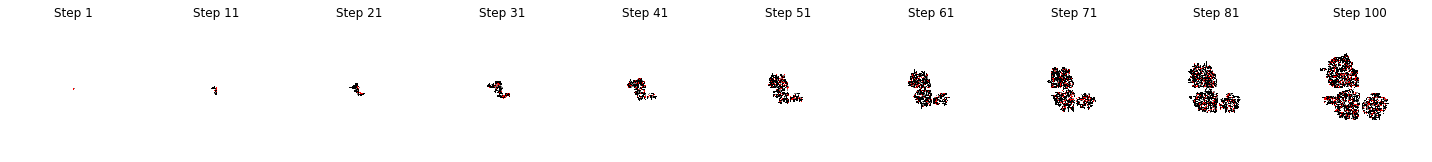

Normal Cells:  {20408} Cancer cells:  {1457} Effector Cells:  {303} Dead Cells:  {332}
Langton's λ: 0.33745019920318725
0.6575 0.2 0.4 0.4


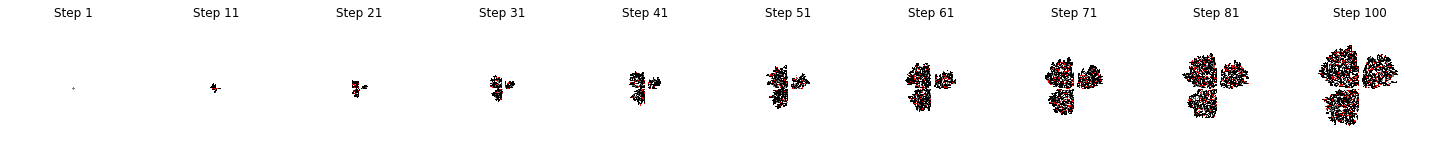

Normal Cells:  {19270} Cancer cells:  {2340} Effector Cells:  {435} Dead Cells:  {455}
Langton's λ: 0.34429673771869507
0.735 0.2 0.4 0.4


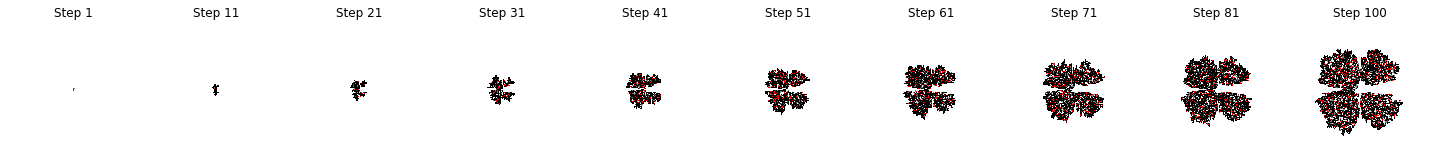

Normal Cells:  {17348} Cancer cells:  {3802} Effector Cells:  {692} Dead Cells:  {658}
Langton's λ: 0.35177635410599883
0.8125 0.2 0.4 0.4


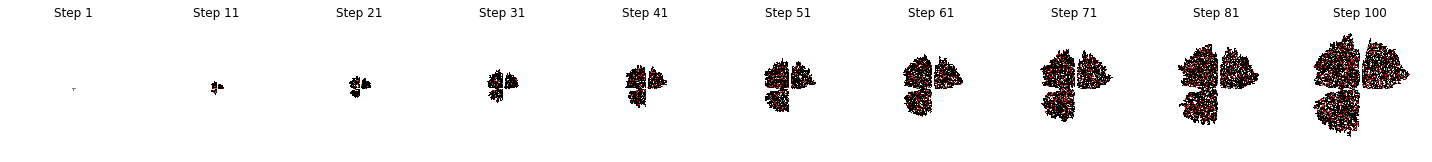

Normal Cells:  {16869} Cancer cells:  {4306} Effector Cells:  {694} Dead Cells:  {631}
Langton's λ: 0.36894609814963797
0.89 0.2 0.4 0.4


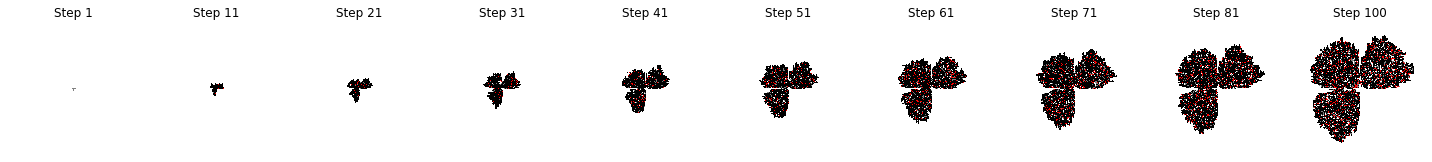

Normal Cells:  {15755} Cancer cells:  {5280} Effector Cells:  {736} Dead Cells:  {729}
Langton's λ: 0.38274623291088716


In [34]:
# set generations
generations = 100

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS
rho = 3.85 

Ns = []
Cs = []
Es = []
Ds = []

for k1,k2,k3,k4 in zip(k1s,k2s,k34s,k34s):
    print(k1,k2,k3,k4)
    # initialize grid of normal cells
    # M = np.full((ROWS, COLS), 'N')
    N,C,E,D = simulation(k1,k2,k3,k4, rho, ROWS, COLS)
    Ns.append(N)
    Cs.append(C)
    Es.append(E)
    Ds.append(D)
    

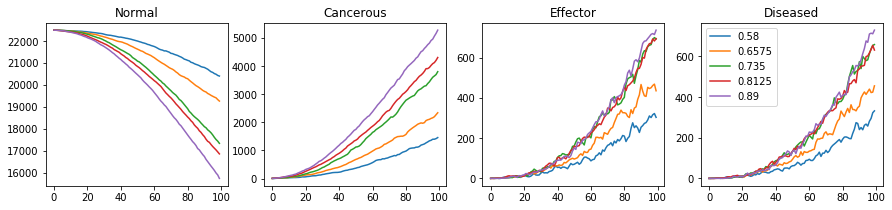

In [64]:
k1s = np.linspace(0.58,0.89,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Ns,Cs,Es,Ds)):
    ax[0].plot(N, label=k1s[i])
    ax[1].plot(C, label=k1s[i])
    ax[2].plot(E, label=k1s[i])
    ax[3].plot(D, label=k1s[i])
ax[0].set_title("Normal")
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# fig.title("Varying k1")
# .ylabel("Number of cells")

## Varying k2

In [51]:
length = 5
k1s = np.full(length,0.75)
k2s = np.linspace(0.2,0.4,length)
k34s = np.full(length,0.4)

0.75 0.2 0.4 0.4


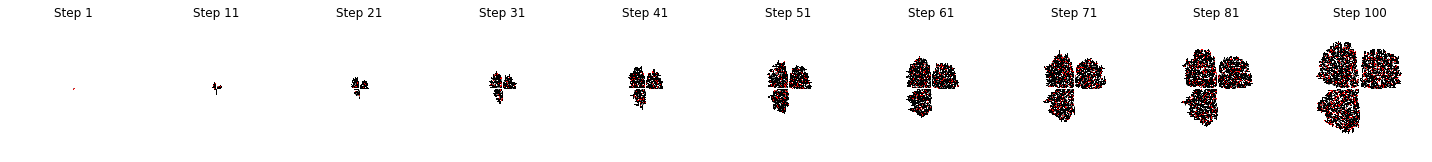

Normal Cells:  {17838} Cancer cells:  {3476} Effector Cells:  {589} Dead Cells:  {597}
Langton's λ: 0.3595430312261995
0.75 0.25 0.4 0.4


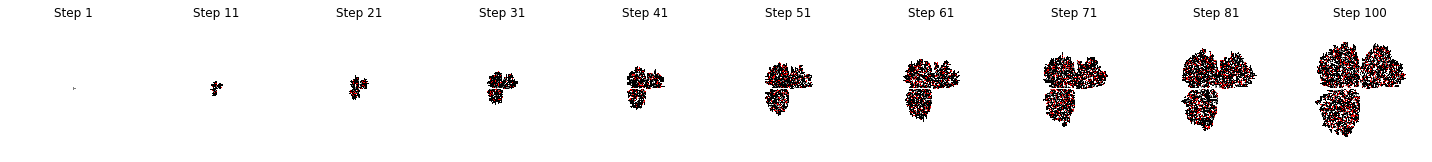

Normal Cells:  {17755} Cancer cells:  {3298} Effector Cells:  {747} Dead Cells:  {700}
Langton's λ: 0.33923705722070846
0.75 0.30000000000000004 0.4 0.4


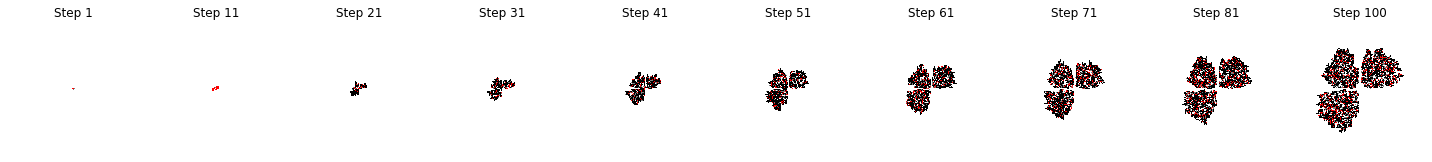

Normal Cells:  {18805} Cancer cells:  {2505} Effector Cells:  {632} Dead Cells:  {558}
Langton's λ: 0.33812537769154927
0.75 0.35000000000000003 0.4 0.4


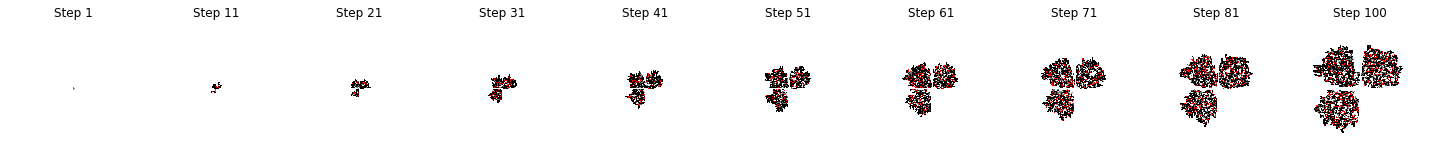

Normal Cells:  {18652} Cancer cells:  {2472} Effector Cells:  {713} Dead Cells:  {663}
Langton's λ: 0.32583626187687104
0.75 0.4 0.4 0.4


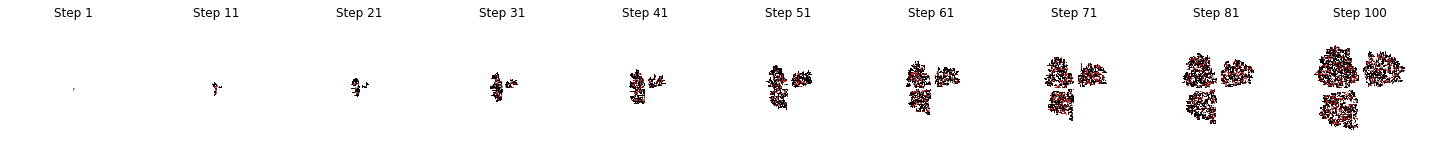

Normal Cells:  {19129} Cancer cells:  {2157} Effector Cells:  {626} Dead Cells:  {588}
Langton's λ: 0.32514752339512426


In [53]:
# set generations
generations = 100

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS
rho = 3.85 

# set generations
generations = 100

Nsk2 = []
Csk2 = []
Esk2 = []
Dsk2 = []

for k1,k2,k3,k4 in zip(k1s,k2s,k34s,k34s):
    print(k1,k2,k3,k4)
    N,C,E,D = simulation(k1,k2,k3,k4, ROWS, COLS)
    Nsk2.append(N)
    Csk2.append(C)
    Esk2.append(E)
    Dsk2.append(D)
    

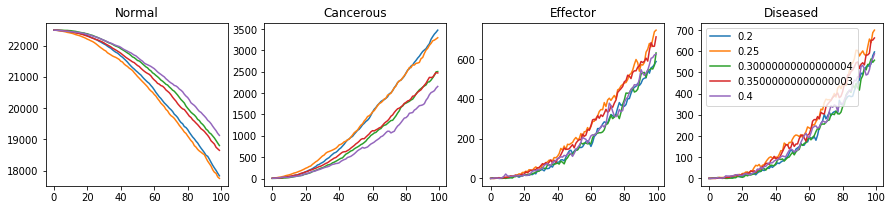

In [66]:
k2s = np.linspace(0.2,0.4,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Nsk2,Csk2,Esk2,Dsk2)):
    ax[0].plot(N,label=k2s[i])
    ax[1].plot(C,label=k2s[i])
    ax[2].plot(E,label=k2s[i])
    ax[3].plot(D,label=k2s[i])
ax[0].set_title("Normal")
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# .ylabel("Number of cells")

## Varying k3

In [48]:
length = 5
k1s = np.full(length,0.75)
k2s = np.full(length,0.2)
k3s = np.linspace(0.2,0.65,length)
k4s = np.full(length,0.4)

0.75 0.2 0.2 0.4


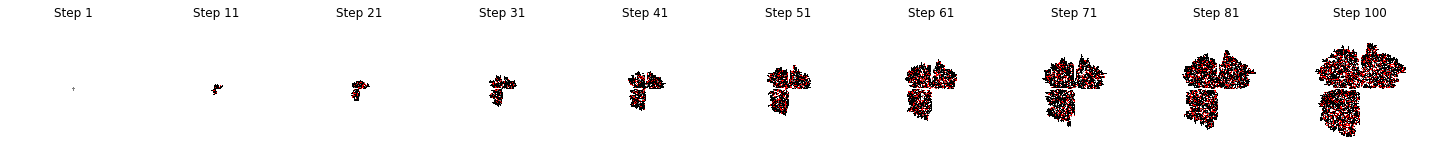

Normal Cells:  {17779} Cancer cells:  {3175} Effector Cells:  {1048} Dead Cells:  {498}
Langton's λ: 0.3700038331532913
0.75 0.2 0.3125 0.4


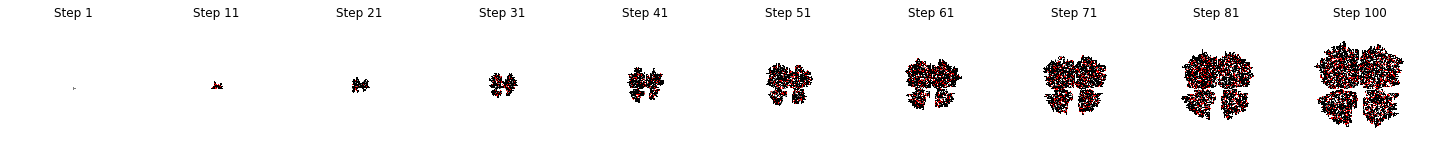

Normal Cells:  {17175} Cancer cells:  {3805} Effector Cells:  {895} Dead Cells:  {625}
Langton's λ: 0.35832075730552887
0.75 0.2 0.42500000000000004 0.4


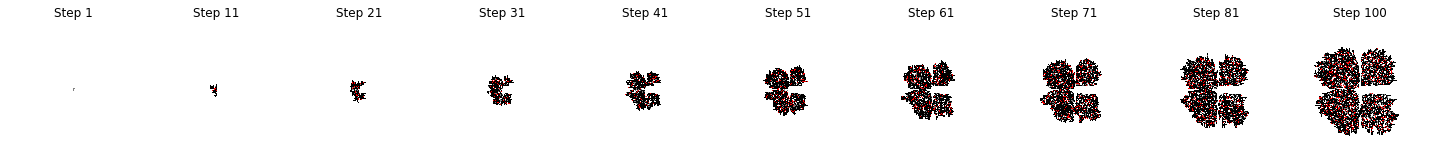

Normal Cells:  {16881} Cancer cells:  {4127} Effector Cells:  {766} Dead Cells:  {726}
Langton's λ: 0.35071942446043164
0.75 0.2 0.5375000000000001 0.4


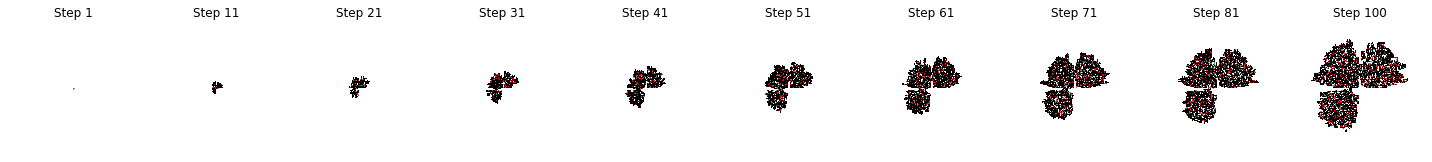

Normal Cells:  {17616} Cancer cells:  {3732} Effector Cells:  {523} Dead Cells:  {629}
Langton's λ: 0.35506591027432927
0.75 0.2 0.65 0.4


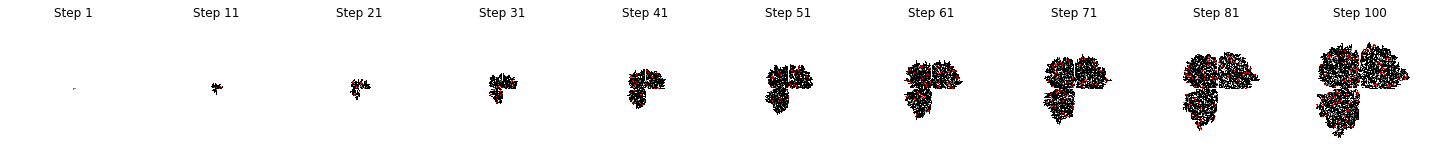

Normal Cells:  {17437} Cancer cells:  {3908} Effector Cells:  {470} Dead Cells:  {685}
Langton's λ: 0.3534275876460768


In [49]:
# set generations
generations = 100

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS
rho = 3.85 

Nsk3 = []
Csk3 = []
Esk3 = []
Dsk3 = []

for k1,k2,k3,k4 in zip(k1s,k2s,k3s,k4s):
    print(k1,k2,k3,k4)
    N,C,E,D = simulation(k1,k2,k3,k4, rho, ROWS, COLS)
    Nsk3.append(N)
    Csk3.append(C)
    Esk3.append(E)
    Dsk3.append(D)
    

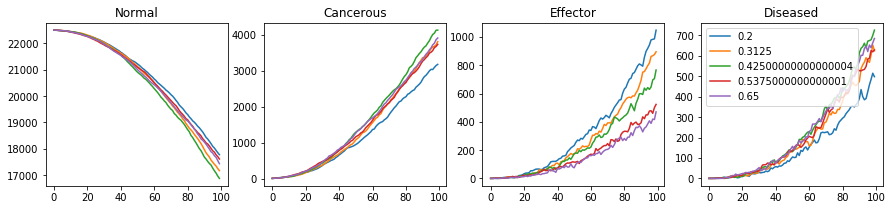

In [68]:
k3s = np.linspace(0.2,0.65,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Nsk3,Csk3,Esk3,Dsk3)):
    ax[0].plot(N,label=k3s[i])
    ax[1].plot(C,label=k3s[i])
    ax[2].plot(E,label=k3s[i])
    ax[3].plot(D,label=k3s[i])
ax[0].set_title("Normal")
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# .ylabel("Number of cells")

## Varying k4


In [55]:
length = 5
k1s = np.full(length,0.75)
k2s = np.full(length,0.2)
k3s = np.full(length,0.4)
k4s = np.linspace(0.1,0.4,length)

0.75 0.2 0.4 0.1


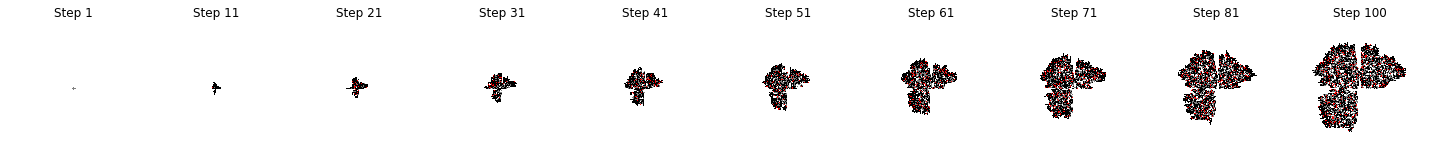

Normal Cells:  {17844} Cancer cells:  {2779} Effector Cells:  {454} Dead Cells:  {1423}
Langton's λ: 0.3703248031496063
0.75 0.2 0.4 0.17500000000000002


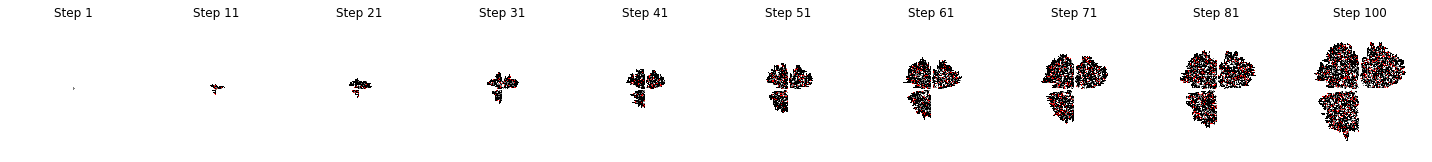

Normal Cells:  {17801} Cancer cells:  {3096} Effector Cells:  {543} Dead Cells:  {1060}
Langton's λ: 0.3659020810437126
0.75 0.2 0.4 0.25


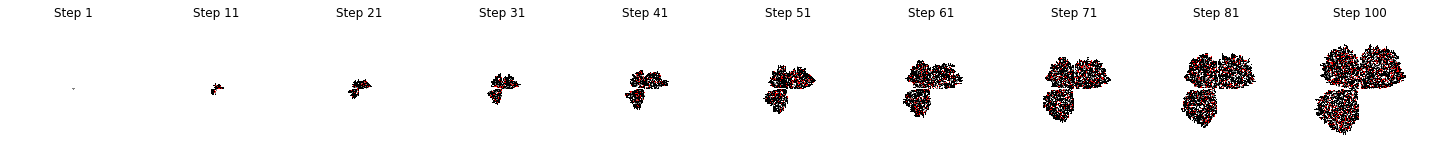

Normal Cells:  {17783} Cancer cells:  {3306} Effector Cells:  {591} Dead Cells:  {820}
Langton's λ: 0.35923651557356295
0.75 0.2 0.4 0.32500000000000007


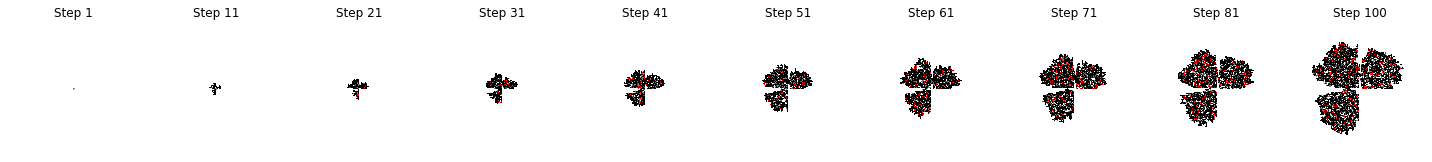

Normal Cells:  {17694} Cancer cells:  {3532} Effector Cells:  {590} Dead Cells:  {684}
Langton's λ: 0.3607760565498571
0.75 0.2 0.4 0.4


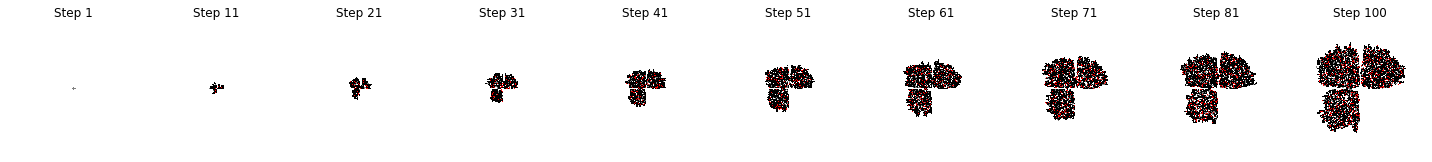

Normal Cells:  {17668} Cancer cells:  {3634} Effector Cells:  {615} Dead Cells:  {583}
Langton's λ: 0.3574482543817425


In [56]:
# set generations
generations = 100

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS
rho = 3.85 

Nsk4 = []
Csk4 = []
Esk4 = []
Dsk4 = []

for k1,k2,k3,k4 in zip(k1s,k2s,k3s,k4s):
    print(k1,k2,k3,k4)
    N,C,E,D = simulation(k1,k2,k3,k4, rho, ROWS, COLS)
    Nsk4.append(N)
    Csk4.append(C)
    Esk4.append(E)
    Dsk4.append(D)
    

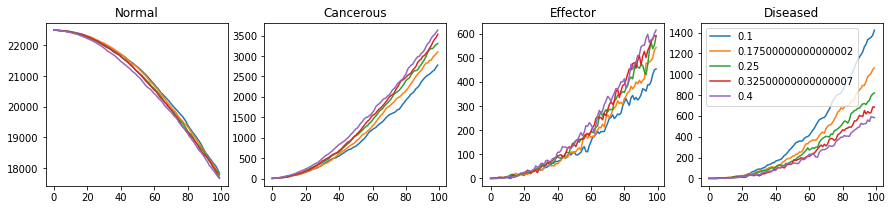

In [69]:
k4s = np.linspace(0.1,0.4,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Nsk4,Csk4,Esk4,Dsk4)):
    ax[0].plot(N,label=k4s[i])
    ax[1].plot(C,label=k4s[i])
    ax[2].plot(E,label=k4s[i])
    ax[3].plot(D,label=k4s[i])
ax[0].set_title("Normal")
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# .ylabel("Number of cells")

## Varying $\rho$

In [76]:
length = 5
k1s = np.full(length,0.75)
k2s = np.full(length,0.2)
k3s = np.full(length,0.4)
k4s = np.full(length,0.4)
rhos = np.linspace(1.5,5,length)

1.5


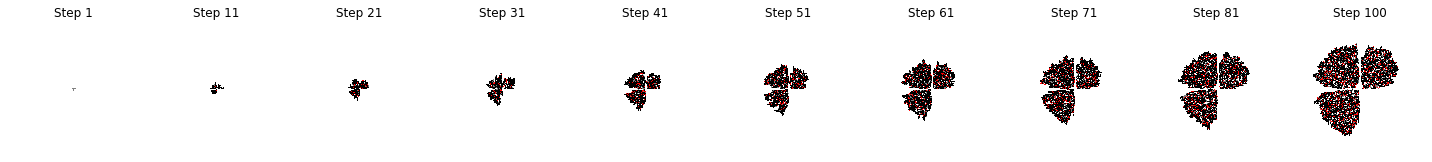

Normal Cells:  {17784} Cancer cells:  {3483} Effector Cells:  {661} Dead Cells:  {572}
Langton's λ: 0.36002175358027677
2.375


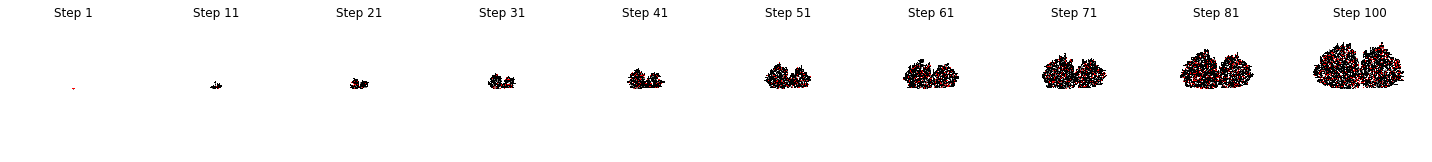

Normal Cells:  {19099} Cancer cells:  {2594} Effector Cells:  {411} Dead Cells:  {396}
Langton's λ: 0.3718267794922847
3.25


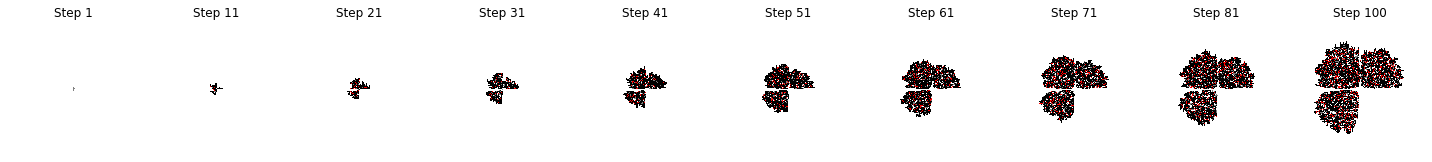

Normal Cells:  {17556} Cancer cells:  {3690} Effector Cells:  {632} Dead Cells:  {622}
Langton's λ: 0.3574570059204962
4.125


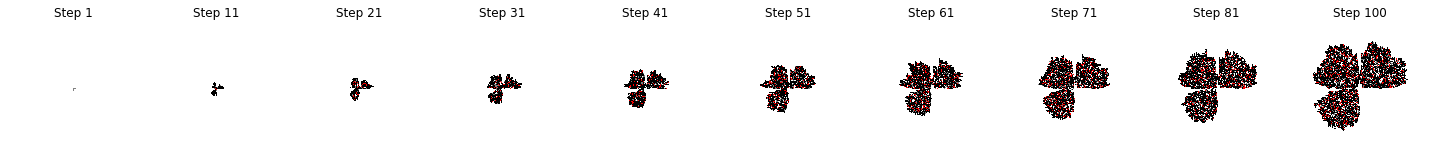

Normal Cells:  {17505} Cancer cells:  {3715} Effector Cells:  {660} Dead Cells:  {620}
Langton's λ: 0.3566580920584533
5.0


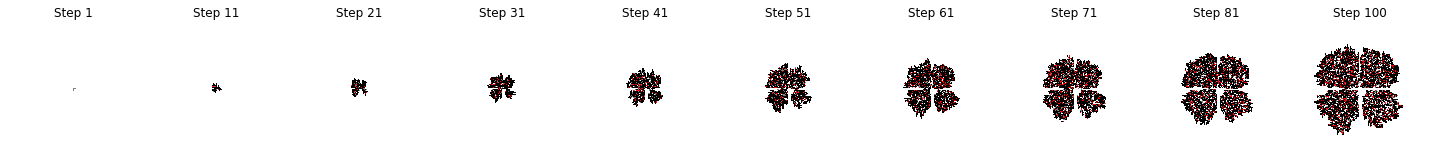

Normal Cells:  {16855} Cancer cells:  {4180} Effector Cells:  {740} Dead Cells:  {725}
Langton's λ: 0.35423585981262085


In [77]:
# set generations
generations = 100

# grid shape and grid origin
ROWS = generations + 50
COLS = generations + 50
origin = (COLS//2, ROWS//2)

phi = ROWS * COLS

Nsrhos = []
Csrhos = []
Esrhos = []
Dsrhos = []

for k1,k2,k3,k4,rho in zip(k1s,k2s,k3s,k4s,rhos):
    print(rho)
    N,C,E,D = simulation(k1,k2,k3,k4, rho, ROWS, COLS)
    Nsrhos.append(N)
    Csrhos.append(C)
    Esrhos.append(E)
    Dsrhos.append(D)
    

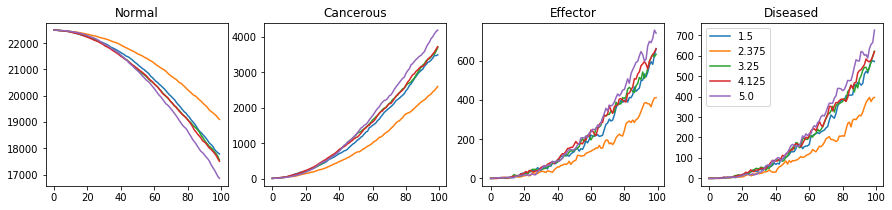

In [78]:
rhos = np.linspace(1.5,5,length)

fig, ax = plt.subplots(1,4, figsize=[15,3])
for i,(N,C,E,D) in enumerate(zip(Nsrhos,Csrhos,Esrhos,Dsrhos)):
    ax[0].plot(N,label=rhos[i])
    ax[1].plot(C,label=rhos[i])
    ax[2].plot(E,label=rhos[i])
    ax[3].plot(D,label=rhos[i])
ax[0].set_title("Normal")   
ax[1].set_title("Cancerous")
ax[2].set_title("Effector")
ax[3].set_title("Diseased")
ax[3].legend()
# .ylabel("Number of cells")